In [111]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

folder_path = './' # Specify the folder path where the CSV files are located

# Use glob to get a list of all CSV files in the folder
csv_files = glob.glob(folder_path + '/*.csv')

# Iterate over the CSV files and read them into a DataFrame
dataframes = []
for file in csv_files[1:]:
    df = pd.read_csv(file)
    # Get the base file name without the extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    # Rename the column "Predicted Demand" to the file name
    df.rename(columns={'Predicted Demand': file_name}, inplace=True)
    dataframes.append(df)


# Concatenate the DataFrames into a single DataFrame

start_date = pd.to_datetime('2016-01-10')  # Specify the desired start date

# Iterate over the dictionary and modify the start date of each DataFrame
aligned_dataframes = []
for df in dataframes:  # Assuming you have a list called "dataframes" containing your DataFrames
    df['Date'] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime if needed
    mask = df['Date'] >= start_date
    aligned_df = df.loc[mask].reset_index(drop=True)
    aligned_dataframes.append(aligned_df)

merged_df = pd.concat(aligned_dataframes, axis=1)

# Remove duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Optional: Reset the index if needed
merged_df.reset_index(drop=True, inplace=True)


In [112]:

metrics = ['MAE', 'RMSE', 'MAPE', 'R-squared', 'sMAPE', 'rMAE']
results = []

for column in merged_df.columns:
    if column != 'Date' and column != 'Real Demand':
        diff = np.abs(merged_df[column] - merged_df['Real Demand'])
        metric_values = [
            np.average(diff),#MAE
            np.sqrt(np.mean(diff ** 2)),#RMSE
            np.mean(diff / merged_df['Real Demand']),#MAPE
            r2_score(merged_df['Real Demand'], merged_df[column]),#R-squared
            np.mean(diff/((np.abs(merged_df[column]) + np.abs(merged_df['Real Demand']))/2)), #sMAPE
            np.mean(diff)/np.mean(np.abs(merged_df[column] - merged_df['Real Demand'].shift(7))) #rMAE

        ]
        results.append(metric_values)

metrics_df = pd.DataFrame(results, columns=metrics)
metrics_df.insert(0, 'Column', merged_df.columns[2:])


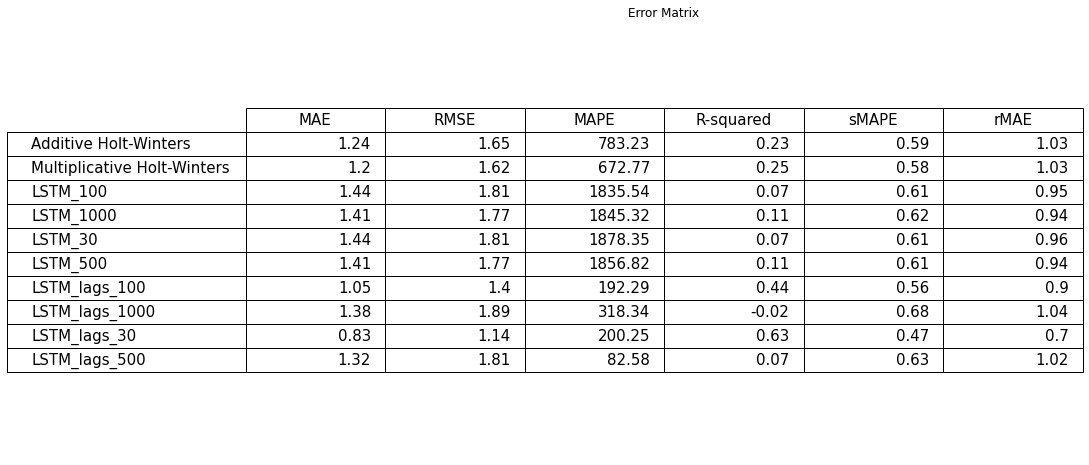

In [113]:
# Set the 'Models' column as the index
metrics_df = metrics_df.round(2)

metrics_df.set_index('Column', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Hide axis labels and ticks
ax.axis('off')

# Create the table using the DataFrame
table = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 rowLabels=metrics_df.index,
                 loc='center')

# Set the table properties
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(1.5, 2)

# Set the title
ax.set_title('Error Matrix')

# Show the plot
plt.show()
